# Voyage Analytics: Integrating MLOps in Travel Productionization of ML Systems


## Importing Libraries

In [1]:
import pandas as pd  
import os
import shutil
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
%matplotlib inline

from statsmodels.stats.weightstats import ztest
from scipy.stats import chi2_contingency

import mlflow
import xgboost as xgb
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error,
                            accuracy_score, precision_score, recall_score, f1_score)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import dagshub

from IPython.display import display

In [34]:
dagshub.init(repo_owner='DURRAINk', repo_name='Voyage_Capstone', mlflow=True)

Accessing as DURRAINk

Initialized MLflow to track repo "DURRAINk/Voyage_Capstone"

Repository DURRAINk/Voyage_Capstone initialized!

## Reading Data

### Flights data

In [4]:
flights_df = pd.read_csv('../data/flights.csv', parse_dates=['date'])
flights_df.head()

travelCode  userCode                from                  to  flightType  \
0           0         0         Recife (PE)  Florianopolis (SC)  firstClass   
1           0         0  Florianopolis (SC)         Recife (PE)  firstClass   
2           1         0       Brasilia (DF)  Florianopolis (SC)  firstClass   
3           1         0  Florianopolis (SC)       Brasilia (DF)  firstClass   
4           2         0        Aracaju (SE)       Salvador (BH)  firstClass   

     price  time  distance       agency       date  
0  1434.38  1.76    676.53  FlyingDrops 2019-09-26  
1  1292.29  1.76    676.53  FlyingDrops 2019-09-30  
2  1487.52  1.66    637.56      CloudFy 2019-10-03  
3  1127.36  1.66    637.56      CloudFy 2019-10-04  
4  1684.05  2.16    830.86      CloudFy 2019-10-10

In [ ]:
profile = ProfileReport(flights_df, title="Flights Data Profile Report",explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 12.81it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Hotels data

In [6]:
hotels_df = pd.read_csv('../data/hotels.csv', parse_dates=['date'])
hotels_df.head()

travelCode  userCode     name               place  days   price    total  \
0           0         0  Hotel A  Florianopolis (SC)     4  313.02  1252.08   
1           2         0  Hotel K       Salvador (BH)     2  263.41   526.82   
2           7         0  Hotel K       Salvador (BH)     3  263.41   790.23   
3          11         0  Hotel K       Salvador (BH)     4  263.41  1053.64   
4          13         0  Hotel A  Florianopolis (SC)     1  313.02   313.02   

        date  
0 2019-09-26  
1 2019-10-10  
2 2019-11-14  
3 2019-12-12  
4 2019-12-26

In [ ]:
profile = ProfileReport(hotels_df, title="Hotels Data Profile Report",explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 95.33it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Users data

In [7]:
users_df = pd.read_csv('../data/users.csv')
users_df.head()

code company             name  gender  age
0     0    4You        Roy Braun    male   21
1     1    4You   Joseph Holsten    male   37
2     2    4You    Wilma Mcinnis  female   48
3     3    4You     Paula Daniel  female   23
4     4    4You  Patricia Carson  female   44

In [ ]:
profile = ProfileReport(users_df, title="Users Data Profile Report",explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 155.05it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Price prediction model

In [ ]:
flights_df

travelCode  userCode                 from                   to  \
0                0         0          Recife (PE)   Florianopolis (SC)   
1                0         0   Florianopolis (SC)          Recife (PE)   
2                1         0        Brasilia (DF)   Florianopolis (SC)   
3                1         0   Florianopolis (SC)        Brasilia (DF)   
4                2         0         Aracaju (SE)        Salvador (BH)   
...            ...       ...                  ...                  ...   
271883      135941      1339    Campo Grande (MS)   Florianopolis (SC)   
271884      135942      1339   Florianopolis (SC)           Natal (RN)   
271885      135942      1339           Natal (RN)   Florianopolis (SC)   
271886      135943      1339   Florianopolis (SC)  Rio de Janeiro (RJ)   
271887      135943      1339  Rio de Janeiro (RJ)   Florianopolis (SC)   

        flightType    price  time  distance       agency       date  
0       firstClass  1434.38  1.76    676.53  FlyingDrops 2019-09-26  
1       firstClass  1292.29  1.76    676.53  FlyingDrops 2019-09-30  
2       firstClass  1487.52  1.66    637.56      CloudFy 2019-10-03  
3       firstClass  1127.36  1.66    637.56      CloudFy 2019-10-04  
4       firstClass  1684.05  2.16    830.86      CloudFy 2019-10-10  
...            ...      ...   ...       ...          ...        ...  
271883  firstClass  1446.34  1.49    573.81      CloudFy 2020-07-12  
271884    economic   726.95  1.84    709.37      CloudFy 2020-07-16  
271885    economic   873.07  1.84    709.37      CloudFy 2020-07-20  
271886    economic   313.62  1.21    466.30      CloudFy 2020-07-23  
271887    economic   533.69  1.21    466.30      CloudFy 2020-07-26  

[271888 rows x 10 columns]

Text(0.5, 1.0, 'Distribution of Flight Prices')

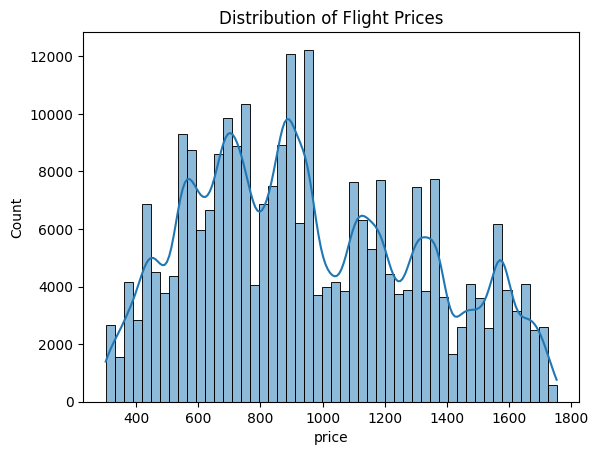

In [ ]:
sns.histplot(data=flights_df, x='price', bins=50, kde=True)
plt.title('Distribution of Flight Prices')

### Feature Engineering

Analysing features and their contribution to the target variable 'price' can provide insights into pricing strategies and customer preferences.

1. As `travelCode` is a Unique id, therefore this feature is not selected

2. For testing that every user with `userCode` spent same price for same distance ...
* Using two sampled z-test
    ```
    H0 = Means of the different user price for same distance is same
    H1 = It significantly differs
    ```

In [ ]:
# Analysing `userCode` Feature
from_ = 'Florianopolis (SC)'
to = 'Aracaju (SE)'
for_dist = flights_df[(flights_df['from']== from_) & (flights_df['to']== to)]
sample1 = for_dist.query("userCode == 3")['price'].values
sample2 = for_dist.query("userCode == 2")['price'].values

z_stat, p_value = ztest(sample1, sample2)
print("Z statistic:", z_stat)
print("p-value:", p_value)

Z statistic: -0.059764022018445814
p-value: 0.9523435806038404


* As there is a very little difference, due to `Agency` and p-value is near 1
the Null Hypothesis is Accepted

3. Analysing `date` feature, whether the price changes across time

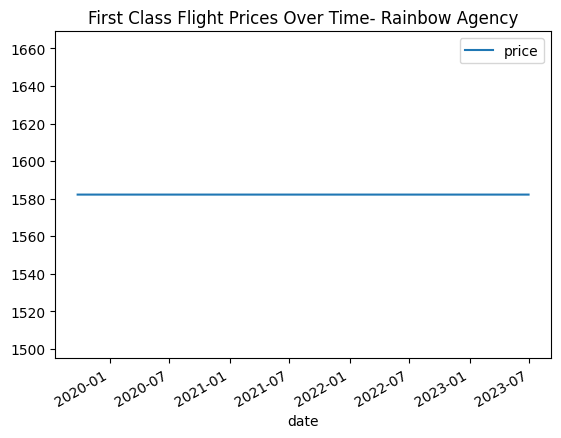

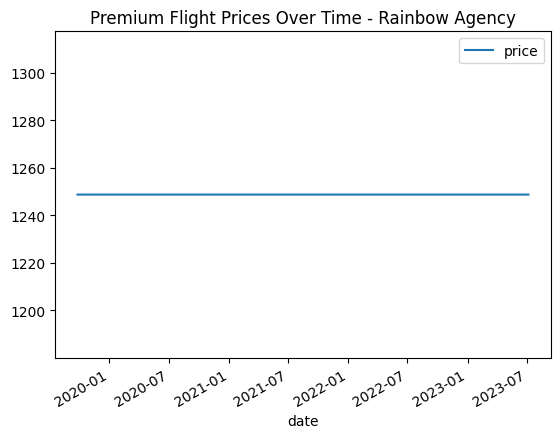

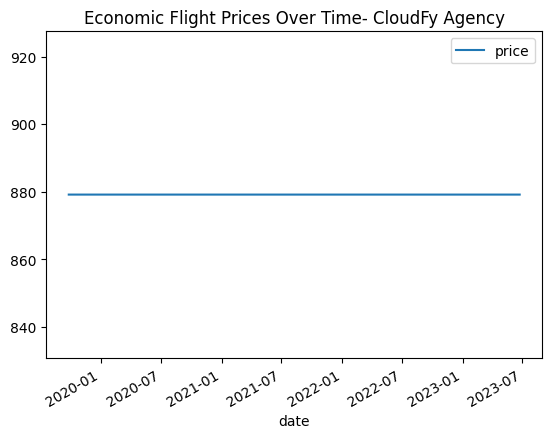

In [ ]:
for_date = for_dist.sort_values(by='date')

for_date.query("flightType == 'firstClass' & agency == 'Rainbow'").plot(x='date',
                                                                         y='price', kind='line',
                                                                         title='First Class Flight Prices Over Time- Rainbow Agency')
for_date.query("flightType == 'premium' & agency == 'Rainbow'").plot(x='date',
                                                                     y='price', kind='line',
                                                                     title='Premium Flight Prices Over Time - Rainbow Agency')
for_date.query("flightType == 'economic'  & agency == 'CloudFy'").plot(x='date',
                                                                    y='price', kind='line',
                                                                    title='Economic Flight Prices Over Time- CloudFy Agency')
plt.show()

* time does not affect the price

In [ ]:
flights_df.drop_duplicates(subset=['from', 'to', 'distance'],keep='first', inplace=False)

travelCode  userCode                 from                   to  \
0                0         0          Recife (PE)   Florianopolis (SC)   
1                0         0   Florianopolis (SC)          Recife (PE)   
2                1         0        Brasilia (DF)   Florianopolis (SC)   
3                1         0   Florianopolis (SC)        Brasilia (DF)   
4                2         0         Aracaju (SE)        Salvador (BH)   
...            ...       ...                  ...                  ...   
133573       66786       648   Florianopolis (SC)           Natal (RN)   
179352       89676       885   Florianopolis (SC)  Rio de Janeiro (RJ)   
179353       89676       885  Rio de Janeiro (RJ)   Florianopolis (SC)   
179364       89682       885   Florianopolis (SC)        Salvador (BH)   
179365       89682       885        Salvador (BH)   Florianopolis (SC)   

        flightType    price  time  distance       agency       date  
0       firstClass  1434.38  1.76    676.53  FlyingDrops 2019-09-26  
1       firstClass  1292.29  1.76    676.53  FlyingDrops 2019-09-30  
2       firstClass  1487.52  1.66    637.56      CloudFy 2019-10-03  
3       firstClass  1127.36  1.66    637.56      CloudFy 2019-10-04  
4       firstClass  1684.05  2.16    830.86      CloudFy 2019-10-10  
...            ...      ...   ...       ...          ...        ...  
133573     premium  1114.55  1.84    709.37      Rainbow 2020-10-04  
179352  firstClass   549.55  1.21    466.30      Rainbow 2019-10-10  
179353  firstClass   941.27  1.21    466.30      Rainbow 2019-10-12  
179364    economic   898.67  2.44    937.77      CloudFy 2019-11-21  
179365    economic   943.15  2.44    937.77      CloudFy 2019-11-23  

[70 rows x 10 columns]

In [ ]:
flights_df.drop_duplicates(subset=['distance'],keep='first', inplace=False).sort_values(by=['from', 'to'])

travelCode  userCode                from                   to  \
6                3         0        Aracaju (SE)    Campo Grande (MS)   
74              37         0        Aracaju (SE)   Florianopolis (SC)   
56              28         0        Aracaju (SE)           Natal (RN)   
58              29         0        Aracaju (SE)          Recife (PE)   
62              31         0        Aracaju (SE)  Rio de Janeiro (RJ)   
4                2         0        Aracaju (SE)        Salvador (BH)   
50              25         0        Aracaju (SE)       Sao Paulo (SP)   
10               5         0       Brasilia (DF)         Aracaju (SE)   
18               9         0       Brasilia (DF)    Campo Grande (MS)   
2                1         0       Brasilia (DF)   Florianopolis (SC)   
36              18         0       Brasilia (DF)           Natal (RN)   
46              23         0       Brasilia (DF)          Recife (PE)   
80              40         0       Brasilia (DF)  Rio de Janeiro (RJ)   
22              11         0       Brasilia (DF)        Salvador (BH)   
20              10         0       Brasilia (DF)       Sao Paulo (SP)   
92990        46495       453   Campo Grande (MS)   Florianopolis (SC)   
93004        46502       453   Campo Grande (MS)           Natal (RN)   
93022        46511       453   Campo Grande (MS)  Rio de Janeiro (RJ)   
92992        46496       453   Campo Grande (MS)        Salvador (BH)   
92994        46497       453   Campo Grande (MS)       Sao Paulo (SP)   
179352       89676       885  Florianopolis (SC)  Rio de Janeiro (RJ)   
179364       89682       885  Florianopolis (SC)        Salvador (BH)   
133572       66786       648          Natal (RN)   Florianopolis (SC)   
133470       66735       648          Natal (RN)  Rio de Janeiro (RJ)   
133538       66769       648          Natal (RN)        Salvador (BH)   
40              20         0         Recife (PE)    Campo Grande (MS)   
0                0         0         Recife (PE)   Florianopolis (SC)   
30              15         0         Recife (PE)           Natal (RN)   
82              41         0         Recife (PE)  Rio de Janeiro (RJ)   
38              19         0         Recife (PE)        Salvador (BH)   
16               8         0         Recife (PE)       Sao Paulo (SP)   
133508       66754       648      Sao Paulo (SP)   Florianopolis (SC)   
133476       66738       648      Sao Paulo (SP)           Natal (RN)   
133494       66747       648      Sao Paulo (SP)  Rio de Janeiro (RJ)   
133472       66736       648      Sao Paulo (SP)        Salvador (BH)   

        flightType    price  time  distance       agency       date  
6         economic   743.54  1.69    650.10      Rainbow 2019-10-17  
74      firstClass  1499.93  2.10    808.85  FlyingDrops 2020-06-11  
56         premium   427.25  0.46    176.33      Rainbow 2020-04-09  
58        economic   604.14  1.44    555.74      CloudFy 2020-04-16  
62      firstClass  1190.94  1.55    597.61  FlyingDrops 2020-04-30  
4       firstClass  1684.05  2.16    830.86      CloudFy 2019-10-10  
50        economic   446.73  1.02    392.76      Rainbow 2020-03-19  
10      firstClass  1287.52  1.11    425.98  FlyingDrops 2019-10-31  
18        economic   583.60  0.72    277.70      CloudFy 2019-11-28  
2       firstClass  1487.52  1.66    637.56      CloudFy 2019-10-03  
36        economic   791.66  1.43    550.69      CloudFy 2020-01-30  
46         premium   568.38  0.63    242.21      CloudFy 2020-03-05  
80        economic   371.04  0.48    183.37      Rainbow 2020-07-02  
22         premium  1268.97  1.76    676.56      Rainbow 2019-12-12  
20      firstClass   992.17  0.67    257.81      Rainbow 2019-12-05  
92990      premium  1030.13  1.49    573.81      Rainbow 2019-10-10  
93004   firstClass   778.01  0.65    250.68      Rainbow 2019-11-28  
93022   firstClass  1609.81  2.09    806.48  FlyingDrops 2020-01-30  
92992   firstClass  1149.38  1.36    522.34      

In [ ]:
from_ = 'Brasilia (DF)'
to = 'Florianopolis (SC)'
flights_df[(flights_df['from']== from_) & (flights_df['to']== to)]

travelCode  userCode           from                  to  flightType  \
2                1         0  Brasilia (DF)  Florianopolis (SC)  firstClass   
48              24         0  Brasilia (DF)  Florianopolis (SC)  firstClass   
96              48         0  Brasilia (DF)  Florianopolis (SC)    economic   
104             52         0  Brasilia (DF)  Florianopolis (SC)    economic   
186             93         1  Brasilia (DF)  Florianopolis (SC)    economic   
...            ...       ...            ...                 ...         ...   
271795      135897      1338  Brasilia (DF)  Florianopolis (SC)    economic   
271831      135915      1339  Brasilia (DF)  Florianopolis (SC)    economic   
271843      135921      1339  Brasilia (DF)  Florianopolis (SC)  firstClass   
271877      135938      1339  Brasilia (DF)  Florianopolis (SC)     premium   
271879      135939      1339  Brasilia (DF)  Florianopolis (SC)     premium   

          price  time  distance   agency       date  
2       1487.52  1.66    637.56  CloudFy 2019-10-03  
48      1576.97  1.66    637.56  Rainbow 2020-03-12  
96       884.94  1.66    637.56  CloudFy 2020-08-27  
104      889.07  1.66    637.56  Rainbow 2020-09-24  
186      884.94  1.66    637.56  CloudFy 2019-10-24  
...         ...   ...       ...      ...        ...  
271795   884.94  1.66    637.56  CloudFy 2019-10-27  
271831   889.07  1.66    637.56  Rainbow 2020-01-13  
271843  1487.52  1.66    637.56  CloudFy 2020-02-21  
271877  1189.32  1.66    637.56  CloudFy 2020-06-21  
271879  1222.24  1.66    637.56  Rainbow 2020-06-26  

[7779 rows x 10 columns]

### Model Developement and Mlflow logging

In [8]:
def log_price_pred_model(model, X, y,  run_name: str = "price_prediction_run",
                          model_name: str = "default_model", params: dict = None,tags: dict = None):

    mlflow.set_experiment('Price_Prediction_Models')
    with mlflow.start_run(run_name=run_name):
        # Log parameters if provided
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)

        if tags:
            mlflow.set_tags(tags)

        X_train,X_test, y_train, y_test = train_test_split(X, y,
                                            test_size=0.2,
                                            random_state=42)

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Compute metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        # Log metrics
        mlflow.log_metric("r2_score", r2)
        mlflow.log_metric("mean_absolute_error", mae)
        mlflow.log_metric("mean_squared_error", mse)
        # Log model depending on type
        if isinstance(model, xgb.XGBModel):
            mlflow.xgboost.log_model(model, name = model_name,
                                     registered_model_name=model_name,
                                     tags=tags, input_example=X_test[:5])
        else:
            mlflow.sklearn.log_model(model, name = model_name,
                                     registered_model_name=model_name,
                                     tags=tags, input_example=X_test[:5])

In [10]:
selected_features = ['from', 'to', 'agency', 'flightType']
label_features = ['from', 'to']
onehot_features = ['agency']
ordinal_features = ['flightType']
X = flights_df[selected_features]
y = flights_df['price']

preprocessor = ColumnTransformer(
    transformers=[
        ('label', OrdinalEncoder(), label_features),
        ('onehot', OneHotEncoder(sparse_output=False), onehot_features),
        ('ordinal', OrdinalEncoder(categories=[['economic', 'premium', 'firstClass']]), ordinal_features)
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

log_price_pred_model(pipeline, X, y, run_name='DecisionTreeRegressor2',
                        model_name='DecisionTreeRegressor_model',
                        params={'random_state': 42},
                        tags={'model_type': 'DecisionTreeRegressor', 'Scaler': 'None',
                              'label encoder': str(label_features),
                              'onehot encoder': str(onehot_features),
                              'ordinal encoder': str(ordinal_features)
                              })

2026/02/08 17:55:26 INFO mlflow.models.model: Found the following environment variables used during model inference: [TMDB_API_KEY]. Please check if you need to set them when deploying the model. To disable this message, set environment variable `MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING` to `false`.
Registered model 'DecisionTreeRegressor_model' already exists. Creating a new version of this model...
2026/02/08 17:55:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeRegressor_model, version 2
Created version '2' of model 'DecisionTreeRegressor_model'.


🏃 View run DecisionTreeRegressor2 at: https://dagshub.com/DURRAINk/Voyage_Capstone.mlflow/#/experiments/4/runs/11f3a423ed5e47b6b2408e713a37e029
🧪 View experiment at: https://dagshub.com/DURRAINk/Voyage_Capstone.mlflow/#/experiments/4


### Selecting the best Model

In [35]:
# Or load a specific version 
def load_model(model_name: str, version: int, dir_path: str = "temp_model_dir"):
    dir_path = f'models/{dir_path}'
    model_uri = f"models:/{model_name}/{version}"
    if os.path.exists(dir_path) and os.path.isdir(dir_path): # Delete the directory and all its contents 
        shutil.rmtree(dir_path) 
        print(f"Deleted directory: {dir_path}")
    model = mlflow.pyfunc.load_model(model_uri=model_uri)
    mlflow.sklearn.save_model(model, f"{dir_path}")
    print(f"Model '{model_name}' version {version} loaded and saved to 'models/{dir_path}' successfully.")


In [36]:
load_model(model_name='DecisionTreeRegressor_model', version=2,dir_path='price_prediction_model')

Deleted directory: models/price_prediction_model


Model 'DecisionTreeRegressor_model' version 2 loaded and saved to 'models/models/price_prediction_model' successfully.


## Gender Classification 

In [7]:
users_df.rename(columns={'code':'userCode'}, inplace=True)
users_df

userCode        company              name  gender  age
0            0           4You         Roy Braun    male   21
1            1           4You    Joseph Holsten    male   37
2            2           4You     Wilma Mcinnis  female   48
3            3           4You      Paula Daniel  female   23
4            4           4You   Patricia Carson  female   44
...        ...            ...               ...     ...  ...
1335      1335  Umbrella LTDA  Albert Garroutte    male   23
1336      1336  Umbrella LTDA        Kim Shores  female   40
1337      1337  Umbrella LTDA     James Gimenez    male   28
1338      1338  Umbrella LTDA      Viola Agosta  female   52
1339      1339  Umbrella LTDA    Paul Rodriguez    male   35

[1340 rows x 5 columns]

### Feature Engineering

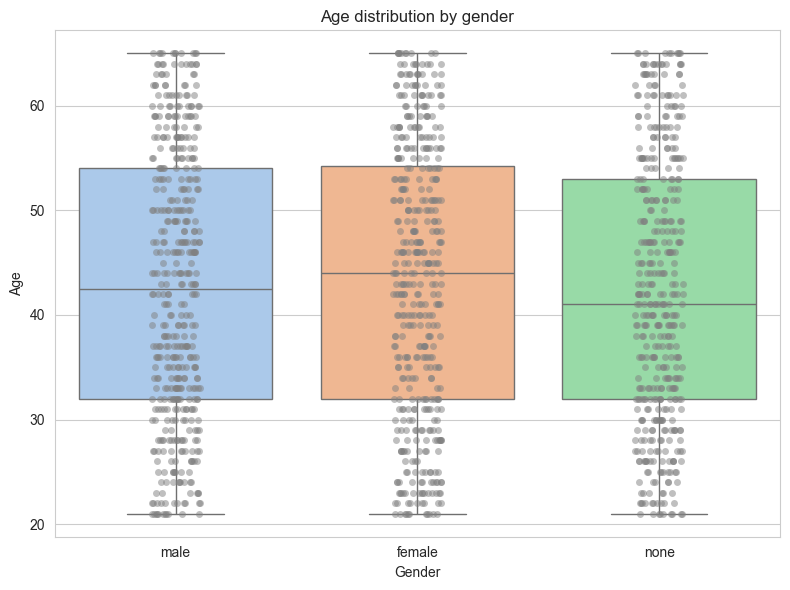

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
ax = sns.boxplot(x='gender', y='age',hue='gender', data=users_df, palette='pastel')
sns.stripplot(x='gender', y='age', data=users_df, color='gray', alpha=0.5, jitter=True)
ax.set_title('Age distribution by gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Age')
plt.tight_layout()
plt.show()

* Age is uniformly distributed 
* Gender is having similar age statistics 

* Merging users data with hotels data to find helpful features

In [10]:
users_hotels_df = pd.merge(hotels_df, users_df, on='userCode', how='left')
display(users_hotels_df.head())
display(users_hotels_df.groupby('gender').describe().T)

travelCode  userCode   name_x               place  days   price    total  \
0           0         0  Hotel A  Florianopolis (SC)     4  313.02  1252.08   
1           2         0  Hotel K       Salvador (BH)     2  263.41   526.82   
2           7         0  Hotel K       Salvador (BH)     3  263.41   790.23   
3          11         0  Hotel K       Salvador (BH)     4  263.41  1053.64   
4          13         0  Hotel A  Florianopolis (SC)     1  313.02   313.02   

        date company     name_y gender  age  
0 2019-09-26    4You  Roy Braun   male   21  
1 2019-10-10    4You  Roy Braun   male   21  
2 2019-11-14    4You  Roy Braun   male   21  
3 2019-12-12    4You  Roy Braun   male   21  
4 2019-12-26    4You  Roy Braun   male   21

gender                                   female  \
travelCode count                        13690.0   
           mean                    67840.706209   
           min                            100.0   
           25%                          32811.0   
           50%                          70944.5   
           75%                        102085.25   
           max                         135894.0   
           std                     40491.839976   
userCode   count                        13690.0   
           mean                      666.283784   
           min                              2.0   
           25%                            316.0   
           50%                            687.0   
           75%                           1012.0   
           max                           1338.0   
           std                       401.388935   
days       count                        13690.0   
           mean                        2.506063   
           min                              1.0   
           25%                              1.0   
           50%                              3.0   
           75%                              4.0   
           max                              4.0   
           std                         1.121711   
price      count                        13690.0   
           mean                      213.432152   
           min                            60.39   
           25%                           165.99   
           50%                           242.88   
           75%                           263.41   
           max                           313.02   
           std                        77.296127   
total      count                        13690.0   
           mean                      535.570359   
           min                            60.39   
           25%                           247.62   
           50%                           497.97   
           75%                           742.86   
           max                          1252.08   
           std                       320.593355   
date       count                          13690   
           mean   2021-01-09 05:11:08.458728960   
           min              2019-09-26 00:00:00   
           25%              2020-04-02 00:00:00   
           50%              2020-11-19 00:00:00   
           75%              2021-09-02 00:00:00   
           max              2023-07-13 00:00:00   
           std                              NaN   
age        count                        13690.0   
           mean                       43.328561   
           min                             21.0   
           25%                             32.0   
           50%                             44.0   
           75%                             55.0   
           max                             65.0   
           std                          13.0637   

gender                                     male                           none  
travelCode count                        13585.0                        13277.0  
           mean                    70456.345823                   65381.514122  
           min                              0.0                          624.0  
           25%                          35441.0                        32967.0  
           50%                          72280.0                        58926.0  
           75%                         104220.0                       101199.0  
           max                         135942.0                       135214.0  
           std                     38665.801688                   38861.766785  
userCode   count                        13585.0                        13277.0  
           mean                      692.169893                     641.873917  
           min                              0.0                            5.0  
           25%                            338.0                          318.0  
           50%                         

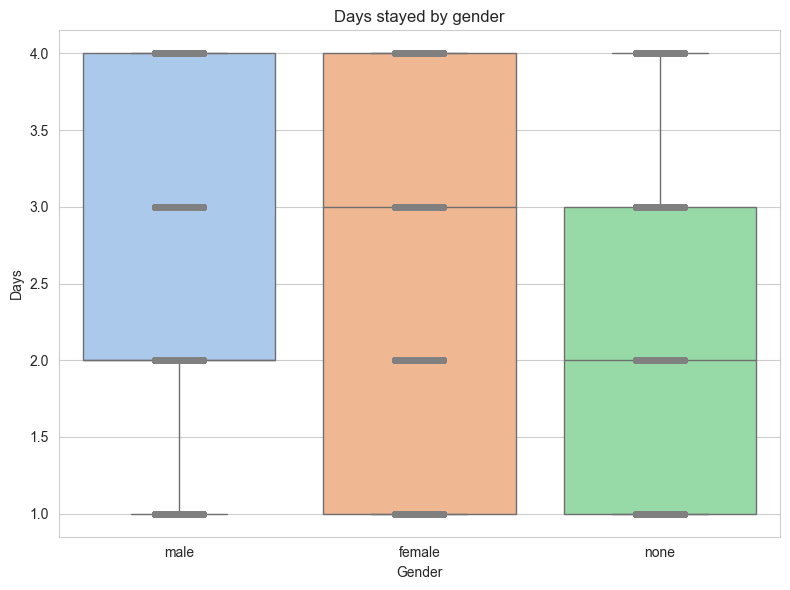

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
ax = sns.boxplot(x='gender', y='days',hue='gender', data=users_hotels_df, palette='pastel')
sns.stripplot(x='gender', y='days', data=users_hotels_df, color='gray', alpha=0.5, jitter=True)
ax.set_title('Days stayed by gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Days')
plt.tight_layout()
plt.show()

In [ ]:
users_hotels_df.groupby('company')['gender'].value_counts()

company        gender
4You           none      5065
               female    4773
               male      4176
Acme Factory   male      2733
               female    2589
               none      2343
Monsters CYA   none      2250
               male      1903
               female    1785
Umbrella LTDA  male      2204
               female    2124
               none      1901
Wonka Company  male      2569
               female    2419
               none      1718
Name: count, dtype: int64

<Axes: xlabel='company', ylabel='Count'>

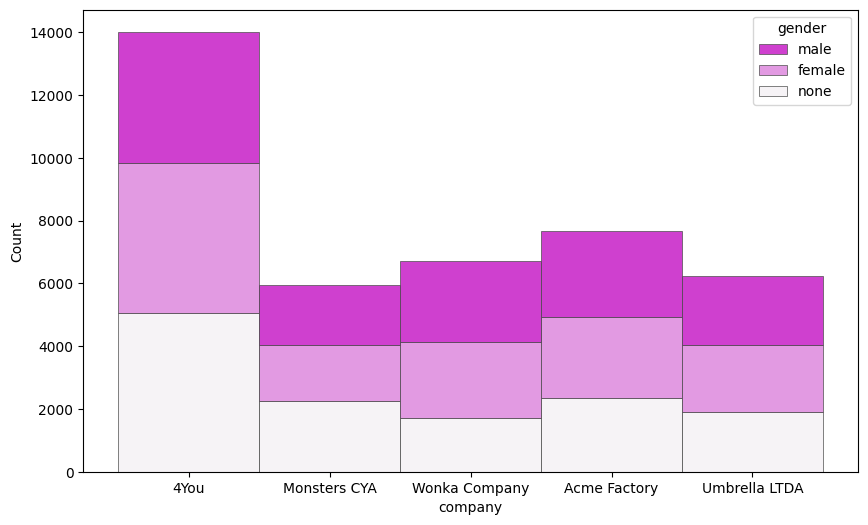

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=users_hotels_df, x='company', hue='gender', multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)

In [ ]:
users_hotels_df.groupby(['name_x','gender'])['price'].count()

name_x    gender
Hotel A   female    1103
          male      1100
          none      1127
Hotel AF  female    1650
          male      1579
          none      1599
Hotel AU  female    1504
          male      1501
          none      1462
Hotel BD  female    1610
          male      1609
          none      1610
Hotel BP  female    1470
          male      1497
          none      1470
Hotel BW  female    1517
          male      1431
          none      1385
Hotel CB  female    1714
          male      1679
          none      1636
Hotel K   female    1733
          male      1759
          none      1602
Hotel Z   female    1389
          male      1430
          none      1386
Name: price, dtype: int64

<Axes: xlabel='name_x', ylabel='Count'>

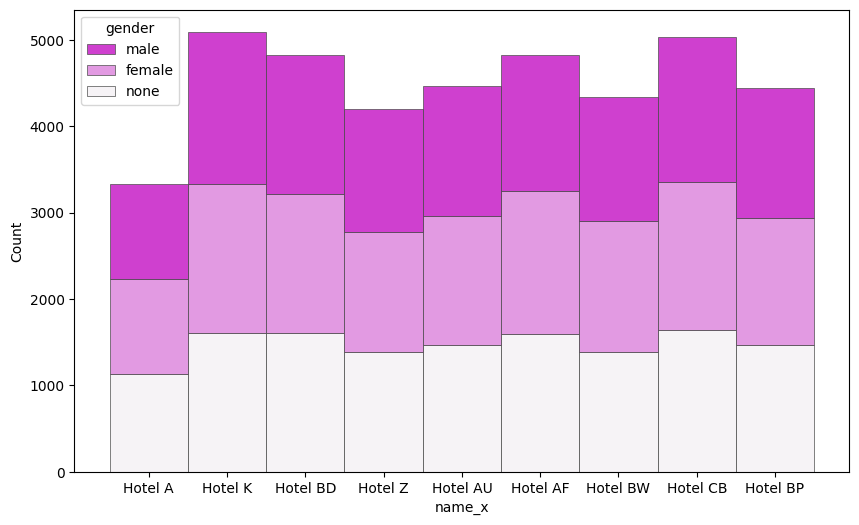

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=users_hotels_df, x='name_x', hue='gender', multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)

In [ ]:
users_flights_df = pd.merge(flights_df, users_df, on='userCode', how='left')
display(users_flights_df.head())

travelCode  userCode                from                  to  flightType  \
0           0         0         Recife (PE)  Florianopolis (SC)  firstClass   
1           0         0  Florianopolis (SC)         Recife (PE)  firstClass   
2           1         0       Brasilia (DF)  Florianopolis (SC)  firstClass   
3           1         0  Florianopolis (SC)       Brasilia (DF)  firstClass   
4           2         0        Aracaju (SE)       Salvador (BH)  firstClass   

     price  time  distance       agency       date company       name gender  \
0  1434.38  1.76    676.53  FlyingDrops 2019-09-26    4You  Roy Braun   male   
1  1292.29  1.76    676.53  FlyingDrops 2019-09-30    4You  Roy Braun   male   
2  1487.52  1.66    637.56      CloudFy 2019-10-03    4You  Roy Braun   male   
3  1127.36  1.66    637.56      CloudFy 2019-10-04    4You  Roy Braun   male   
4  1684.05  2.16    830.86      CloudFy 2019-10-10    4You  Roy Braun   male   

   age  
0   21  
1   21  
2   21  
3   21  
4   21

<Axes: xlabel='flightType', ylabel='Count'>

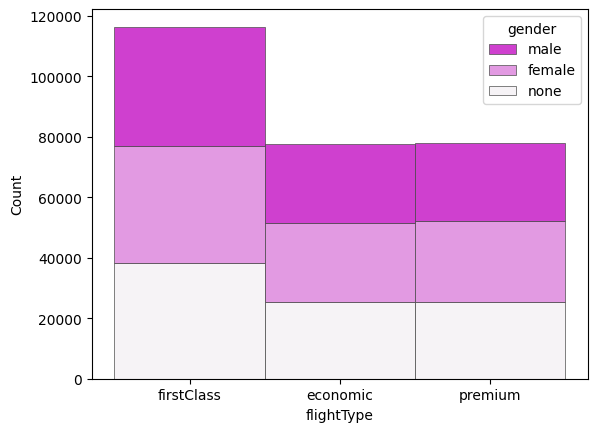

In [51]:

sns.histplot(data=users_flights_df, x='flightType', hue='gender', multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)

<Axes: xlabel='agency', ylabel='Count'>

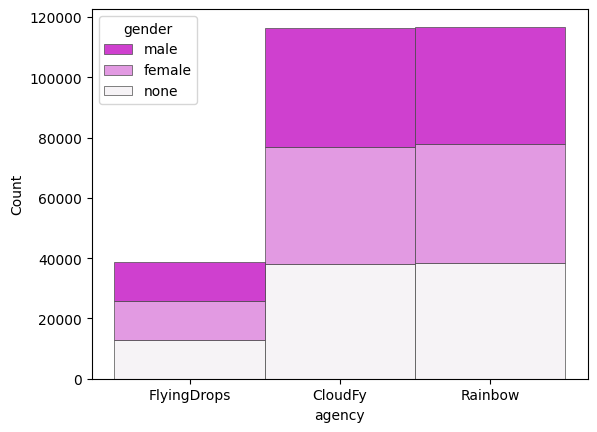

In [52]:
sns.histplot(data=users_flights_df, x='agency', hue='gender', multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)

### Ml models and Mlflow loggings

In [53]:
def log_gender_pred_model(model, X, y,  run_name: str = "gender_prediction_run",
                          model_name: str = "default_model", params: dict = None,tags: dict = None):

    mlflow.set_experiment('Gender_Prediction_Models')
    with mlflow.start_run(run_name=run_name):
        # Log parameters if provided
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)

        if tags:
            mlflow.set_tags(tags)

        X_train,X_test, y_train, y_test = train_test_split(X, y,
                                            test_size=0.2,
                                            random_state=42)

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Compute metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        rec = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')


        # Log metrics
        mlflow.log_metric("accuracy_score", acc)
        mlflow.log_metric("precision_score", prec)
        mlflow.log_metric("recall_score", rec)
        mlflow.log_metric("f1_score", f1)
       
        # Log model depending on type
        if isinstance(model, xgb.XGBModel):
            mlflow.xgboost.log_model(model, name = model_name,
                                     registered_model_name=model_name,tags=tags,
                                     input_example=X_test.iloc[:5])
        else:
            mlflow.sklearn.log_model(model, name = model_name,
                                     registered_model_name=model_name,tags=tags,
                                     input_example=X_test.iloc[:5])

* A Simple Lofistic Regression Model

In [ ]:
selected_features = ['name_x', 'place', 'days', 'company','age']
encod_features = ['name_x', 'place', 'company']
preprocessor = ColumnTransformer(
    transformers=[
        ('label', OrdinalEncoder(), encod_features)])
classif_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))])

x = users_hotels_df[selected_features]
y = users_hotels_df['gender']

log_gender_pred_model(classif_pipeline, x, y,
                        run_name='LogisticRegression1',
                        model_name='LogisticRegression_model',
                        params={'random_state': 42},
                        tags={'model_type': 'LogisticRegression',
                              'selected_features': str(selected_features),
                              'label encoded': str(encod_features)
                              })

"log_gender_pred_model(classif_pipeline, x, y,\n                        run_name='LogisticRegression1',\n                        model_name='LogisticRegression_model',\n                        params={'random_state': 42},\n                        tags={'model_type': 'LogisticRegression',\n                              'selected_features': str(selected_features),\n                              'label encoded': str(encod_features)\n                              })"

* Randomforest Model with extracted Features

In [54]:
label_encode = ['name_x', 'place'] 
onehot = ['company']
preprocessor = ColumnTransformer(
    transformers=[
        ('label', OrdinalEncoder(), label_encode),
        ('onehot', OneHotEncoder(sparse_output=False), onehot)])
classif_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=21,random_state=42))])
log_gender_pred_model(classif_pipeline, x, y,
                        run_name='RandomForest1',
                        model_name='RandomForest_model',
                        params={'n_estimators': 21, 'random_state': 42},
                        tags={'model_type': 'RandomForestClassifier',
                              'selected_features': str(selected_features),
                              'label encoded': str(encod_features),
                              'onehot encoded': str(onehot)
                              })

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Registered model 'RandomForest_model' already exists. Creating a new version of this model...
2026/02/07 18:20:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForest_model, version 2
Created version '2' of model 'RandomForest_model'.


🏃 View run RandomForest1 at: https://dagshub.com/DURRAINk/Voyage_Capstone.mlflow/#/experiments/5/runs/bb7e97972e164ad79153877681bd1880
🧪 View experiment at: https://dagshub.com/DURRAINk/Voyage_Capstone.mlflow/#/experiments/5


### Selecting the Best model

In [64]:
load_model(model_name='RandomForest_model', version=2,dir_path="gender_classification_model")

Model 'RandomForest_model' version 2 loaded and saved to 'models/models/gender_classification_model' successfully.


## Recommendation model

In [ ]:
hotels_df

travelCode  userCode      name               place  days   price  \
0               0         0   Hotel A  Florianopolis (SC)     4  313.02   
1               2         0   Hotel K       Salvador (BH)     2  263.41   
2               7         0   Hotel K       Salvador (BH)     3  263.41   
3              11         0   Hotel K       Salvador (BH)     4  263.41   
4              13         0   Hotel A  Florianopolis (SC)     1  313.02   
...           ...       ...       ...                 ...   ...     ...   
40547      135938      1339  Hotel BP       Brasilia (DF)     3  247.62   
40548      135939      1339  Hotel BP       Brasilia (DF)     1  247.62   
40549      135940      1339  Hotel BW   Campo Grande (MS)     3   60.39   
40550      135941      1339  Hotel BW   Campo Grande (MS)     3   60.39   
40551      135942      1339  Hotel BD          Natal (RN)     4  242.88   

         total       date  
0      1252.08 2019-09-26  
1       526.82 2019-10-10  
2       790.23 2019-11-14  
3      1053.64 2019-12-12  
4       313.02 2019-12-26  
...        ...        ...  
40547   742.86 2020-06-18  
40548   247.62 2020-06-25  
40549   181.17 2020-07-02  
40550   181.17 2020-07-09  
40551   971.52 2020-07-16  

[40552 rows x 8 columns]

### Feature Engineering

* it is seen that each hotel belongs to a specific city and are not randomly distributed across cities
* Therefore testing it using chi2 test
1. Null Hypothesis = Hotels are are not randomly distributed across cities.
2. Alternate Hypothesis = Hotels are city specific

In [ ]:
# cross tabulation between place and hotel name
con = pd.crosstab(hotels_df.place,hotels_df.name)
display(con)
# Run chi-square test
chi2, p, dof, expected = chi2_contingency(con)
print(f"Chi2: {chi2:.2f}, p-value: {p:.4f}")
if p < 0.05:
    print("Reject Null Hypothesis!")

name                 Hotel A  Hotel AF  Hotel AU  Hotel BD  Hotel BP  \
place                                                                  
Aracaju (SE)               0         0         0         0         0   
Brasilia (DF)              0         0         0         0      4437   
Campo Grande (MS)          0         0         0         0         0   
Florianopolis (SC)      3330         0         0         0         0   
Natal (RN)                 0         0         0      4829         0   
Recife (PE)                0         0      4467         0         0   
Rio de Janeiro (RJ)        0         0         0         0         0   
Salvador (BH)              0         0         0         0         0   
Sao Paulo (SP)             0      4828         0         0         0   

name                 Hotel BW  Hotel CB  Hotel K  Hotel Z  
place                                                      
Aracaju (SE)                0         0        0     4205  
Brasilia (DF)               0         0        0        0  
Campo Grande (MS)        4333         0        0        0  
Florianopolis (SC)          0         0        0        0  
Natal (RN)                  0         0        0        0  
Recife (PE)                 0         0        0        0  
Rio de Janeiro (RJ)         0      5029        0        0  
Salvador (BH)               0         0     5094        0  
Sao Paulo (SP)              0         0        0        0

Chi2: 324416.00, p-value: 0.0000
Reject Null Hypothesis!


* Chi2: 324416.00, p-value: 0.0000 are indicating that Hotels are city specific

### Model Developement and MLflow Logging

In [13]:
def log_hotel_rec_model(model, X, y,  run_name: str = "Hotel_recommendation_run",
                          model_name: str = "default_model", params: dict = None,tags: dict = None):

    mlflow.set_experiment('Hotel_Recommendation_Models')
    with mlflow.start_run(run_name=run_name):
        # Log parameters if provided
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)

        if tags:
            mlflow.set_tags(tags)

        X_train,X_test, y_train, y_test = train_test_split(X, y,
                                            test_size=0.2,
                                            random_state=42)

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Compute metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        rec = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')


        # Log metrics
        mlflow.log_metric("accuracy_score", acc)
        mlflow.log_metric("precision_score", prec)
        mlflow.log_metric("recall_score", rec)
        mlflow.log_metric("f1_score", f1)
       
        # Log model depending on type
        if isinstance(model, xgb.XGBModel):
            mlflow.xgboost.log_model(model, name = model_name,
                                     registered_model_name=model_name,
                                     tags=tags, input_example=X_test.iloc[:5])
        else:
            mlflow.sklearn.log_model(model, name = model_name,
                                      registered_model_name=model_name,tags=tags,
                                        input_example=X_test.iloc[:5])

1. A Simple KNN Model

In [ ]:
sel_features = ['place', 'days']
X = hotels_df[sel_features]
l_en = LabelEncoder()
y = l_en.fit_transform(hotels_df['name'])
knn_preprocessor = ColumnTransformer(
    transformers=[
        ('label', OrdinalEncoder(), sel_features)])
knn_pipeline = Pipeline(steps=[
    ('preprocessor', knn_preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=len(l_en.classes_)))
])

log_hotel_rec_model(knn_pipeline, X, y,
                    run_name="KNN_Hotel_Rec", 
                    model_name="KNN_Hotel_Model",
                    params={'n_neighbors': len(l_en.classes_)},
                    tags={'model_type': 'KNeighborsClassifier', 
                          'selected_features': str(sel_features),
                          'label_encoder': 'place'
                          })

### Selecting the best model

In [12]:
load_model(model_name='KNN_Hotel_Model', version=2, dir_path="hotel_recommendation_model")

Deleted directory: models/hotel_recommendation_model


Model 'KNN_Hotel_Model' version 2 loaded and saved to 'models/models/hotel_recommendation_model' successfully.


# Thankyou!

In [9]:
hotels_df.place.unique()

array(['Florianopolis (SC)', 'Salvador (BH)', 'Natal (RN)',
       'Aracaju (SE)', 'Recife (PE)', 'Sao Paulo (SP)',
       'Campo Grande (MS)', 'Rio de Janeiro (RJ)', 'Brasilia (DF)'],
      dtype=object)